# Decision Trees and Random Forests


---



![](https://i.ytimg.com/vi/ZVR2Way4nwQ/maxresdefault.jpg)
*Image from the youtube channel Normalized Nerd - Decision Tree Classification Clearly Explained!*


Decision trees are among the most powerful Machine Learning tools available today and are used in a wide variety of real-world applications from Medical diagnosis to stock prices prediction. Yet they are intuitive, easy to interpret — and easy to implement.

In this tutorial we will learn how to implement a binary decision tree from scratch.

# Goal of this notebook

Our goal is to predict if a patient has Diabetes or not based on 8 medical features that will be shown later.

We will implement a binary decision tree in order to acheive such a task.
The decision tree will be trained based on medical data extracted from a dataset provided by Vikas Ukani on kaggle.

The dataset is composed of 8 features and 2 classes (has diabetes or doesn't have diabetes).

Let's load the dataset and extract its data

In [ ]:
!gdown --id 1EZvKRxJ_r7lEFY3GMlxgzBQbhs1hqLZe
import pandas as pd
import numpy as np

# Load data.
df = pd.read_csv("/content/diabetes-dataset.csv.xls", delimiter=",")
data = df.to_numpy()
X = data[:, :-1] # all columns but the last
y = np.array(data[:, -1], dtype=np.int) # expected to be from 0 to n_classes - 1

print(X.shape)
print(y.shape)

feature_names=[col for col in df.columns]
class_names=["No", "Yes"]

# Visualize data
df.head()

Downloading...
From: https://drive.google.com/uc?id=1EZvKRxJ_r7lEFY3GMlxgzBQbhs1hqLZe
To: /content/diabetes-dataset.csv.xls
100% 62.1k/62.1k [00:00<00:00, 51.1MB/s]
(2000, 8)
(2000,)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Now that we have our data let us explain how decision tree work.

# Decision tree

### Principle

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

The tree is composed of nodes. The top node is called the root and nodes at the bottom, which doesn't have any children are leaf nodes.
In a decision tree classifier the predictions are made by traversing the tree from root to leaf.

In a binary tree, at each node, we go right if a feature is less than a threshold, left otherwise (see image below). Finally, each leaf is associated with a class, which is the output of the predictor.

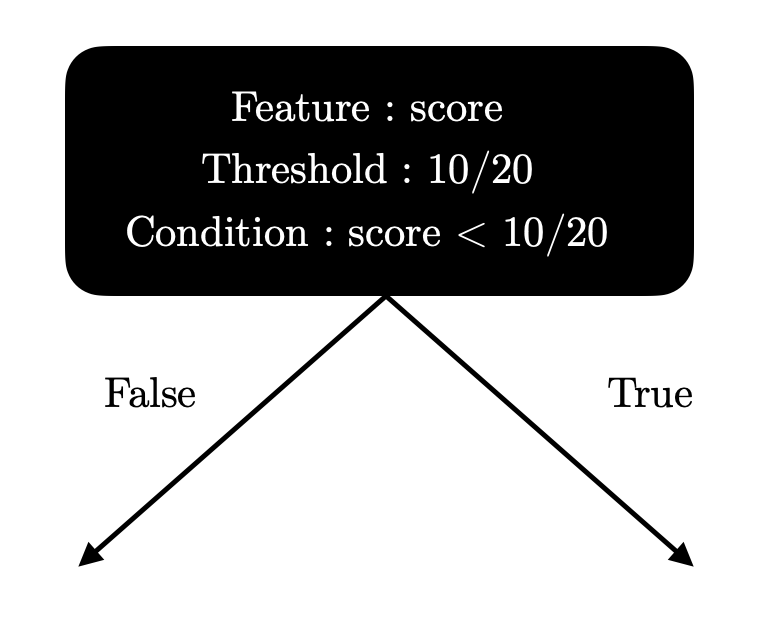

However using random features and threshold values at each node won't optimize the prediction. Therefore the model needs to learn which features to take and the corresponding correct threshold values to optimally split the data and get the correct prediction. 

To decide which split is better, a metric called the gini index is used (another attribute selection criterion can be used such as Entropy but the gini index is the most used in decision trees).

### Metric used

Decision trees use the concept of Gini impurity to describe how homogeneous a node is. A node is homogeneous (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

It is defined as follows :
$$G = 1 - \sum_{k=1}^{n}{p_k}^2$$

where $p_k$ is the fraction of samples belonging to class k and n is the number of classes.

# CART algorithm 
The CART algorithm is the algorithm responsible for creating the decision tree recursively. It starts by splitting the root so that the Gini impurity of the two children node (average of the Gini of the children nodes weighted by the size of the node i.e. the number of samples that will pass through each node) is minimized. It then does the same thing for each children node considering them as the new root to be split. 

It stops when the depth of the tree (number of layers in the tree) reaches a hyperparameter called maximum depth, or if no more splits lead to children purer than their parents (gini smaller).








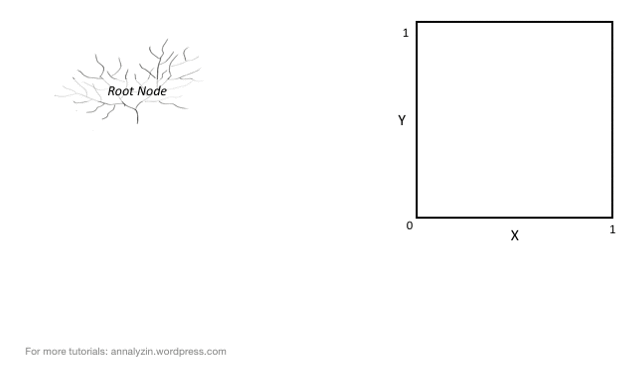



---

Now that you know how decision tree work in theory, let's go through each step in detail.

You will:
1. Experiment on how to make a simple decision tree by visualizing the data;
2. Learn to implement the best_split and CART algorithm that grows the tree programmatically;
3. Grow your own tree and predict if a patient has diabetes or not with test data.

# Learn how spliting works and how we can grow a tree out of those splits

### Simple Example of how spliting works

In order to illustrate how spliting works we are going to work with another dataset in which the features are much more discriminant (so that we can better visualize the different classes). Here we load a dataset which contains multiple features of iris flowers and labels the flower according to these features).

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris["target"] = iris.target
df_iris["class"] = iris.target_names[iris.target]

# Visualize data
df_iris.sample(n=5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,class
93,5.0,2.3,3.3,1.0,1,versicolor
116,6.5,3.0,5.5,1.8,2,virginica
37,4.9,3.6,1.4,0.1,0,setosa
10,5.4,3.7,1.5,0.2,0,setosa
42,4.4,3.2,1.3,0.2,0,setosa


##### We are going to work with only two features out of the four available in order to plot the data in 2D and better visualize the data.

Run the hidden cells to get the helper functions that we will need to plot the data

In [ ]:
def color(pred):
  if (pred == 0):
    return 'red'
  elif(pred == 1):
    return 'blue'
  elif(pred == 2):
    return 'orange'
  elif(pred == 3):
    return 'green'
  return 'black'

In [ ]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

# Use only last two features (petal length and width)
# Thus, we can plot a 2D decision boundary

lim = int(0.8 * len(iris.data))

x_train_2feat = iris.data[:, 2:]
y_train_2feat = iris.target


X_iris_test = x_train_2feat[lim:,:2]
y_iris_test = y_train_2feat[lim:]

X_iris = x_train_2feat[:lim,0]
Y_iris = x_train_2feat[:lim,1]
max_y = max(Y_iris)
max_x = max(X_iris)
c_plot = [color(pred) for pred in y_train_2feat[:lim]]

x_i = [0,max_x]
y_i = [0,max_y]
def f(a, b, c, d):
    plt.figure(2)
    plt.scatter(X_iris,Y_iris, c=c_plot)
    plt.plot(x_i, [a,a], c='k', lw=3)
    plt.plot(x_i, [b,b], c='k', lw=3)
    plt.plot([c,c], y_i, c='k', lw=3)
    plt.plot([d,d], y_i, c='k', lw=3)
    plt.ylim(0, max_y)
    plt.xlim(0, max_x)
    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.show()

##### Now run the code below and play with the cursors to try and isolate each class.

Cursors a and b change sepal width and cursors c and d change sepal length.

In [ ]:
interactive_plot = interactive(f, a=(0.0, max_y), b=(0.0, max_y), c=(0.0, max_x), d=(0.0, max_x))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.25, description='a', max=2.5), FloatSlider(value=1.25, description='…

As you can see, not all cursors are necessary to separate each class.
What you have been doing when playing with the cursors and moving the lines around is:


*   selecting a feature (sepal length or sepal width);
*   and assign it a value (the threshold).





#### Now that you have found your splits (feature, threshold), try to build a simple decision tree of depth 2 associated with what you experienced previously. (Try it for 5 min max)

The cursors you have selected correspond to the features and their value to the associated threshold.


*   Try to find a root node (what feature and threshold associated)
*   Walk down the tree based on some of the previous splits you found step by step (The condition at each node is feature < threshold; you go left if true, right in the other case)




#### helper functions

In [ ]:
# import numpy as np

!gdown --id 1YMO1SmMzVrwrp-7iBDjjYNSXpjyBqAW2
from utils_decision_tree import *


class TreeNode():
  def __init__(self, left=None, right=None, predicted_class=None, threshold=None, feature_index=None):
    if (predicted_class is not None):
      self.threshold = None
      self.feature_index = None
      self.left = None
      self.right = None
      self.predicted_class = predicted_class
    else:
      self.threshold = threshold
      self.feature_index = feature_index
      self.left = left
      self.right = right
      self.predicted_class = predicted_class
    


def toNode(tree):
  if (tree is None):
    return None
  node = Node(
      gini=None,
      num_samples=0,
      num_samples_per_class=0,
      predicted_class=tree.predicted_class,
  )
  
  if (tree.threshold is not None and tree.feature_index is not None):
    node.threshold = tree.threshold
    node.feature_index = tree.feature_index

  node_left = toNode(tree.left)
  node_right = toNode(tree.right)
  node.left = node_left
  node.right = node_right

  return node



def predict_test(inputs, tree):
    """Predict class for a single sample."""
    node = tree
    while node.left:
        if inputs[node.feature_index] < node.threshold:
            node = node.left
        else:
            node = node.right
    return node.predicted_class


def accuracy(X,Y, tree):
  n = 0
  for (x,y) in zip(X,Y):
    
    pred = predict_test(x, tree)
    if pred == y:
      n += 1
  return n / len(Y)

Downloading...
From: https://drive.google.com/uc?id=1YMO1SmMzVrwrp-7iBDjjYNSXpjyBqAW2
To: /content/utils_decision_tree.py
100% 3.62k/3.62k [00:00<00:00, 2.65MB/s]


#### Complete the code

In [ ]:
class_names = [
  "Setosa",  # Red on the plot
  "Versicolor", # Blue on the plot
  "Virginica", # Orange on the plot
]

feature_names = [
  "sepale length (cm)", # x-axis of the plot
  "sepal width (cm)" # y-axis of the plot
]

def grow_simple_tree():
  '''
  feature_index = 0 corresponds to sepal length
  feature_index = 1 corresponds to sepal width
  predicted_class = 0 corresponds to setosa
  predicted_class = 1 corresponds to versicolor
  predicted_class = 2 corresponds to virginica

  Tree:
                    Root
      Node / Leaf ___|___ Node / Leaf
            __|__         __|__
           |     |       |     |
          Leaf  Leaf    Leaf  Leaf
  '''
  tree = TreeNode(
      threshold= , # complete
      feature_index= , # complete
      left= TreeNode(
          predicted_class= , # is it a leaf or do we go on ?
          threshold= , # if it's a leaf no need to set this value
          feature_names= , # if it's a leaf no need to set this value
          left= TreeNode(
              
          ), # if it's a leaf no need to add a new node
          right= TreeNode(
              
          ), # if it's a leaf no need to add a new node
      ),
      right= TreeNode(
          predicted_class= , # is it a leaf or do we go on ?
          threshold= , # if it's a leaf no need to set this value
          feature_names= , # if it's a leaf no need to set this value
          left= TreeNode(
              
          ), # if it's a leaf no need to add a new node
          right= TreeNode(
              
          ), # if it's a leaf no need to add a new node
      ),
  )
  return tree

myTree = grow_simple_tree()


#Visualize
tree = toNode(myTree)
tree.debug(feature_names=feature_names, class_names=class_names, show_details=False)

SyntaxError: ignored

#### Correction

In [ ]:
class_names = [
  "Setosa",  # Red on the plot
  "Versicolor", # Blue on the plot
  "Virginica", # Orange on the plot
]

feature_names = [
  "sepale length (cm)", # x-axis of the plot
  "sepal width (cm)" # y-axis of the plot
]

def grow_simple_tree():
  '''
  feature_index = 0 corresponds to sepal length
  feature_index = 1 corresponds to sepal width
  predicted_class = 0 corresponds to setosa
  predicted_class = 1 corresponds to versicolor
  predicted_class = 2 corresponds to virginica
  '''
  tree = TreeNode(
      threshold= 2.3,
      feature_index= 0,
      left= TreeNode(
          predicted_class=0,
      ),
      right= TreeNode(
          threshold= 4.9,
          feature_index= 0,
          left= TreeNode(
              predicted_class=1,
          ),
          right= TreeNode(
              predicted_class=2,
          ),
      ),
  )
  return tree

myTree = grow_simple_tree()


#Visualize
tree = toNode(myTree)
tree.debug(feature_names, class_names, False)

          ┌───────────────────────────┐                                                        
     ┌────┤ sepale length (cm) < 2.30 ├────────────────────────────┐                           
     │    └───────────────────────────┘                            │                           
╔════╧═══╗                                           ┌─────────────┴─────────────┐             
║ Setosa ║                                    ┌──────┤ sepale length (cm) < 4.90 ├──────┐      
╚════════╝                                    │      └───────────────────────────┘      │      
                                       ╔══════╧═════╗                             ╔═════╧═════╗
                                       ║ Versicolor ║                             ║ Virginica ║
                                       ╚════════════╝                             ╚═══════════╝


#### As you'll see, this little decision tree performs quite well

In [ ]:
# accuracy, X_test and y_test are defined in helper functions
acc = accuracy(X_iris_test, y_iris_test, tree)
print(acc)

0.9333333333333333




---



# Doing it programmaticaly

Now that you have understood how spliting works, let's try to do it programmaticaly. At each node, we are going to look for the best pair (feature, threshold) to split the data. But how do we select the threshold ?

What if a feature is continuous? Then you can just sort the values of the feature and take as thresholds the middle between two adjacent values.

Now that the values are sorted, we can use that to easily go through each threshold/feature pair and calculate the Gini. The idea is: 
1. Iterate through the sorted feature values as possible thresholds;
2. Keep track of the number of samples per class on the left and on the right;
3. Increment/decrement them by 1 after each threshold.

Let m be the size of a node and m[k] the number of samples of class k in the node. Then the Gini index of this node is the following:
$$G = 1 - \sum_{k=1}^{n}{p_k}^2 = 1 - \sum_{k=1}^{n}{\left(\frac{m_k}{m}\right)}^2$$

and since after seeing the i-th threshold there are i elements on the left and m–i on the right,

$$G_i^{left} = 1 - \sum_{k=1}^{n}{\left(\frac{m_k^{left}}{i}\right)}^2$$
$$G_i^{right} = 1 - \sum_{k=1}^{n}{\left(\frac{m_k^{right}}{m-i}\right)}^2$$

So the gini index of node i is:

$$G_i = \frac{i}{m}G_i^{left} + \frac{m-i}{m}G_i^{right}$$

#Implement the gini function that will calculate the gini impurity
Help: np.sum(y == x) returns the count of element x in y.

In [ ]:
def gini_index(y, n_classes):
        """Compute Gini impurity of a non-empty node. 
        y is an array of size m of all the samples' classes going through this node : [class_1, class_2, class_1, ...]
        n_classes is the number of classes
        returns a float
        """
        m = y.size # size of the node
        gini = ?
        return gini

SyntaxError: ignored

#### Correction

In [ ]:
 def gini_index(y, n_classes):
        """Compute Gini impurity of a non-empty node. 
        y is an array of size m of all the samples' classes going through this node : [class_1, class_2, class_1, ...]
        n_classes is the number of classes
        returns a float
        """
        m = y.size # size of the node
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(n_classes))
 

#### Test your Gini function

In [ ]:
n_classes = 4
y_gini = np.array([0,1,1,1,3,2,0,2,0,3,3,2])

assert(gini_index(y_gini, n_classes) == 0.75)

#Complete the best_split function

In [ ]:
def best_split(X, y, n_classes, n_features):
    """
    Find the best split for a node.
    "Best" means that the average impurity of the two children, weighted by their
    population, is the smallest possible. Additionally it must be less than the
    impurity of the current node.
    To find the best split, we loop through all the features, and consider all the
    midpoints between adjacent training samples as possible thresholds. We compute
    the Gini impurity of the split generated by that particular feature/threshold
    pair, and return the pair with smallest impurity.
    Returns:
        best_idx: Index of the feature for best split, or None if no split is found.
        best_thr: Threshold to use for the split, or None if no split is found.
    """
    # Need at least two elements to split a node.

    m = y.size
    if m <= 1:
        return None, None

    # Count of each class in the current node.
    num_parent = [np.sum(y == c) for c in range(n_classes)]

    # Gini of current node.
    best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
    best_idx, best_thr = None, None

    # Loop through all features.
    for idx in range(n_features):
        # Sort data along selected feature.
        thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
        

        # We could actually split the node according to each feature/threshold pair
        # and count the resulting population for each class in the children, but
        # instead we compute them in an iterative fashion, making this for loop
        # linear rather than quadratic.
        num_left = [0] * n_classes
        num_right = num_parent.copy()
        for i in range(1, m):  # possible split positions
            c = classes[i - 1]
            num_left[c] += 1
            num_right[c] -= 1

            y_left = [[x] * num_left[x] for x in range(n_classes)]
            y_left = np.array([item for sublist in y_left for item in sublist])
            y_right = [[x] * num_right[x] for x in range(n_classes)]
            y_right = np.array([item for sublist in y_right for item in sublist])
        
            ### Compute Gini index ###

            # gini_left = 
            # gini_right =

            # The Gini impurity of a split is the weighted average of the Gini
            # impurity of the children.
            
            # gini = 

            ##########################


            if thresholds[i] == thresholds[i - 1]:
                    continue

            if gini < best_gini:
                best_gini = gini
                best_idx = idx
                best_thr = (thresholds[i] + thresholds[i - 1]) / 2 

           

    return best_idx, best_thr

####Correction


```python
### Compute Gini index ###

gini_left = gini_index(y_left, n_classes)
gini_right = gini_index(y_right, n_classes)

# The Gini impurity of a split is the weighted average of the Gini
# impurity of the children.
gini = (i * gini_left + (m - i) * gini_right) / m

##########################

```

#Complete the grow_tree function to properly create the decision tree recursively

In [ ]:
def grow_tree(X, y, n_classes, n_features, depth, max_depth):
        """Build a decision tree by recursively finding the best split."""
        # Population for each class in current node. The predicted class is the one with
        # largest population.
        num_samples_per_class = [np.sum(y == i) for i in range(n_classes)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=gini_index(y, n_classes),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        # Split recursively until maximum depth is reached.
        if depth < max_depth:
            idx, thr = best_split(X, y, n_classes, n_features)
            if idx is not None:

                ### DELETE THE HASHTAGS IN FRONT OF THE CORRECT UPDATES TO BE MADE ###

                # indices_left = X[:, idx] < thr
                # indices_left = X[idx, :] < thr
                # X_left, y_left = X[indices_left], y[indices_left]
                # X_right, y_right = X[~indices_left], y[~indices_left]

                # node.feature_index = idx
                # node.threshold = thr

                # node.left = grow_tree(X_left, y_left, n_classes,
                #                       n_features, depth + 1, max_depth)
                # node.right = grow_tree(X_right, y_right, n_classes,
                #                       n_features, depth + 1, max_depth)
                # node.left = grow_tree(X_left, y_left, n_classes,
                #                       n_features, depth, max_depth)
                # node.right = grow_tree(X_right, y_right, n_classes,
                #                       n_features, depth, max_depth)
                

        return node

IndentationError: ignored

# Putting it all together

Here is our DecisionTreeClassifier class all done.
As you can see, we added the mehtod _predict which crosses the tree from root to leaf to return the leaf's predicted class.

Run the following cells and see what tree it grows. You can change the max_depth hyperparameter before fitting the tree.

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
    
    def fit(self, X, y):
        """Build decision tree classifier."""
        self.n_classes_ = len(set(y))  # classes are assumed to go from 0 to n-1
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        """Predict class for X."""
        return [self._predict(inputs) for inputs in X]

    def debug(self, feature_names, class_names, show_details=True):
        """Print ASCII visualization of decision tree."""
        self.tree_.debug(feature_names, class_names, show_details)

    def _gini(self, y):
        # Method you implemented
        return gini_index(y, self.n_classes_)

    def _best_split(self, X, y):
        # Method you implemented
        return best_split(X, y, self.n_classes_, self.n_features_)

    def _grow_tree(self, X, y,depth=0):
        # Method you implemented
        return grow_tree(X,y, self.n_classes_, self.n_features_, depth, self.max_depth)


    def _predict(self, inputs):
        """Predict class for a single sample."""
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

### Here is the full class so that it can fit faster

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
    
    def fit(self, X, y):
        self.n_classes_ = len(set(y))  # classes are assumed to go from 0 to n-1
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def debug(self, feature_names, class_names, show_details=True):
        self.tree_.debug(feature_names, class_names, show_details)

    def _gini(self, y):
        m = y.size
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes_))

    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]

        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        for idx in range(self.n_features_):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):  # possible split positions
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )

                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2  # midpoint

        return best_idx, best_thr

    def _grow_tree(self, X, y,depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        # Split recursively until maximum depth is reached.
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _predict(self, inputs):
        """Predict class for a single sample."""
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

### Let's see what it does

In [ ]:
# Load training and testing datasets

propTrain = 0.8
lim = int(len(X)*propTrain)

# Features
X_test= X[lim:]
X_train = X[:lim]

# labels
y_test = y[lim:]
y_train = y[:lim]

print(X_train.shape)
print(y_train.shape)


(1600, 8)
(1600,)


In [ ]:
MAX_DEPTH = 3

# Fit data.
clf = DecisionTreeClassifier(max_depth=MAX_DEPTH)
clf.fit(X_train, y_train)

# Visualize.
clf.debug(
    feature_names=feature_names,
    class_names=class_names,
)

IndexError: ignored

# Let's take a look at the perfromance

In [ ]:
def accuracy(X,Y, model):
  n = 0
  for (x,y) in zip(X,Y):
    
    pred = model.predict([x])
    if pred == y:
      n += 1
  return n / len(Y)

In [ ]:
print(accuracy(X_test, y_test, clf))

0.775


The following function aims at illustrating the influence of the max-depth parameter on the accuracy of the decision-tree classifier. Complete the following cell in order to plot the accuracy as a function of max-depth in a chosen range.

In [ ]:
def accuracy_plot(low,high,X_train,Y_train,X_test,y_test):
  max_depth_list=[]
  accs = []
  for d in range(low,high+1):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, Y_train)
    acc = accuracy(X_test, y_test, clf)
    max_depth_list.append(int(d))
    accs.append(acc)
  plt.plot(max_depth_list, accs)
  plt.show()

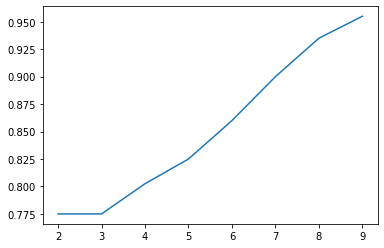

In [ ]:
low= 2 #chose a minimum max_depth
high= 9 #maximum max_depth

accuracy_plot(low,high,X_train,y_train,X_test,y_test) #plot accuracy against max_depth

We can see that it quickly reaches a really good accuracy. However, this means we are overfiting our decision tree.